# Base

In [53]:
import gymnasium as gym
from tqdm import trange
import random
import numpy as np
from mdl import torch as mdl
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from mdl import torch as mdl
import contextlib

class ExpDecay:
    def __init__(self, start, end, unit):
        self.start = start
        self.end = end
        self.unit = unit
    def __call__(self, t):
        return self.end + (self.start - self.end) * math.exp(-1. * t / self.unit)

class EWMA:
    def __init__(self, alpha):
        self.alpha = alpha
        self.value = 0
    def __call__(self, value):
        self.value = self.value * self.alpha + value * (1 - self.alpha)
        return self.value

def show_env(env: gym.Env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    clear_output(wait=True)

class NopContextManager(contextlib.AbstractContextManager):
    def __exit__(self, exc_type, exc_value, traceback):
        return False

class TextTailDisplay(NopContextManager):
    def __init__(self, last_n=1):
        self.tail_display = display(display_id=True)
        self.deque = deque(maxlen=last_n)
    def print(self, line):
        self.deque.append(line)
        md = '  \n'.join(self.deque)
        from IPython.display import Markdown
        self.tail_display.update(Markdown(md))

class MdTailDisplay(NopContextManager):
    def __init__(self, last_n=1):
        self.tail_display = display('<markdown display>', display_id=True)
        self.deque = deque(maxlen=last_n)
    def tuple(self, tuple: namedtuple):
        tuple = tuple.__class__(*[f'{value:.4f}' if isinstance(value, float) else str(value) for value in tuple])
        header = '| ' + ' | '.join([field for field in tuple._fields]) + ' |\n' + '|-' * len(tuple._fields) + '|\n'
        row = '| ' + ' | '.join([f'{getattr(tuple, field)}' for field in tuple._fields]) + ' |' 
        self.deque.append(row)
        md = header + '  \n'.join(self.deque) + '\n'
        from IPython.display import Markdown
        self.tail_display.update(Markdown(md))

class EnvDisplay(NopContextManager):
    def __init__(self):
        self.env_display = display(display_id=True)

    def show_env(self, env: gym.Env):
        img = env.render()
        fig = plt.figure()
        plt.imshow(img)
        plt.axis("off")
        self.env_display.update(fig)
        plt.close(fig)

    def show_envs(self, envs: gym.vector.VectorEnv):
        imgs = envs.call('render')
        fig = plt.figure(figsize=(12, 8))
        for i, img in enumerate(imgs):
            fig.add_subplot((len(imgs)+1)//2, 2, i+1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f'env {i}')
        self.env_display.update(fig)
        plt.close(fig)

class ProgressBoard(mdl.HyperParameters, contextlib.AbstractContextManager):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(8, 2.5), is_display=True):
        self.save_hyperparameters()
        self.display_handler = display(display_id=True)
        self.fig = None

    def close(self):
        if self.fig:
            plt.close(self.fig)

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()
        return False

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        import collections
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) < every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.is_display:
            return
        # mdl.use_svg_display()
        if self.fig is None:
            self.fig = mdl.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(mdl.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k + f'({v[-1].y:.2f})' if len(v) > 0 else '')
        axes = self.axes if self.axes else mdl.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        # if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        self.display_handler.update(self.fig)
        # display.clear_output(wait=True)

def print_q(Q, header='Q:'):
    asym = ['<', 'v', '>', '^']
    print(header)
    for i in range(Q.shape[0]):
        actions = Q[i]
        a = asym[np.argmax(actions)]
        q = np.max(actions)
        print(f'{q:4.2f}{a}', end=' ')
        if i % 4 == 3:
            print()

def random_run(env):
    state, _ = env.reset()
    terminated = truncated = False
    while not terminated and not truncated:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        show_env(env)

def actor_run(env, actor, randn_action=False):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
    terminated = truncated = False
    while not terminated and not truncated:
        with torch.inference_mode():
            if randn_action:
                mean, std = actor(state)
                action = mean
            else:
                action = actor(state)
        observation, reward, terminated, truncated, _ = env.step(action[0].tolist())
        state = torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
        # print(f'terminated {terminated} truncated {truncated} reward {reward}')
        show_env(env)

def random_run_vec(envs):
    display = EnvDisplay()
    states, _ = envs.reset()
    done_once = np.zeros(envs.num_envs, dtype=bool)
    while not done_once.all():
        actions = envs.action_space.sample()
        next_states, rewards, terminated, truncated, _ = envs.step(actions)
        done_once |= terminated | truncated
        display.show_envs(envs)

def actor_run_vec(envs, actor, randn_action=False):
    env_display = EnvDisplay()
    ret_display = MdTailDisplay(1)
    ReturnLog = namedtuple('ReturnLog', [f'env_{i}_return' for i in range(envs.num_envs)])
    state, _ = envs.reset()
    state = torch.tensor(state, dtype=torch.float32, device='cuda')
    done_once = np.zeros(envs.num_envs, dtype=bool)
    returns = np.zeros(envs.num_envs)
    while not done_once.all():
        with torch.inference_mode():
            if randn_action:
                mean, std = actor(state)
                action = mean
            else:
                action = actor(state)
        observation, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
        state = torch.tensor(observation, dtype=torch.float32, device='cuda')
        returns += reward * ~done_once
        done_once |= terminated | truncated
        env_display.show_envs(envs)
        ret_display.tuple(ReturnLog(*returns))
    print(f'returns: {returns}')

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

TransitionWithMask = namedtuple('TransitionWithMask', ('state', 'action', 'next_state', 'reward', 'mask'))
class ReplayMemoryWithMask(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(TransitionWithMask(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

# FrozenLake Q-learning

In [ ]:
seed = random.randint(0, 1000000)
gamma = 0.95
num_iter = 300
alpha = 0.9
epsilon = 0.9
random.seed(seed)
np.random.seed(seed)
reward_count = 0

def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s])

env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="rgb_array")
env.action_space.seed(seed)
env.observation_space.seed(seed)
num_states = env.observation_space.n
num_actions = env.action_space.n
Q = np.zeros((num_states, num_actions))
for k in range(num_iter):
    state, _ = env.reset()
    done = False
    while not done:
        action = e_greedy(env, Q, state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        # update Q
        y = reward + gamma * Q[next_state, np.argmax(Q[next_state, :])]
        Q[state, action] += alpha * (y - Q[state, action])
        state = next_state
    if reward == 1:
        reward_count += 1
        # print(f'state {state} reward {reward} action {action} next_state {next_state}')
    if k % 100 == 0:
        print_q(Q, f'iter: {k}')
# print(f'reward_count: {reward_count}')

state, _ = env.reset()
done = False
while not done:
    action = e_greedy(env, Q, state, 0)
    next_state, reward, done, _, _ = env.step(action)
    state = next_state
show_env(env)

# CartPole DQN

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
# state, _ = env.reset()
# done = False
# while not done:
#     action = env.action_space.sample()
#     next_state, reward, done, _, _ = env.step(action)
#     show_env(env)
# env.close()



class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer_1 = nn.Linear(n_observations, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)

policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to('cuda')
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to('cuda')
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
memory = ReplayMemory(10000)
batch_size = 128
gamma = 0.99
TAU = 0.005

epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1000
def get_epsilon(num_steps):
    return epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * num_steps / epsilon_decay)
num_steps = 0
def select_action(state, training=True):
    global num_steps
    sample = random.random()
    epsilon = get_epsilon(num_steps)
    num_steps += 1
    if not training or sample > epsilon:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    else:
        action = torch.tensor([[env.action_space.sample()]], device='cuda')
    return action

for i_episode in range(600):
    state, _ = env.reset()
    # state (1, 4)
    state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
    for t in count():
        # action (1, 1)
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        # reward (1)
        reward = torch.tensor([reward], device='cuda')
        done = terminated or truncated
        # next_state (1, 4)
        next_state = None if done else torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        # optimize model
        if len(memory) >= batch_size:
            sample = memory.sample(batch_size)
            batch = Transition(*zip(*sample))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device='cuda')
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            # state_batch (128, 4)
            state_batch = torch.cat(batch.state)
            # action_batch (128, 1)
            action_batch = torch.cat(batch.action)
            # reward_batch (128)
            reward_batch = torch.cat(batch.reward)
            # state_action_values (128, 1)
            state_action_values = policy_net(state_batch).gather(1, action_batch)
            # next_state_values (128)
            next_state_values = torch.zeros(batch_size, device='cuda')
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
            # expected_state_action_values (128)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100)
            optimizer.step()
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            print(f'episode {i_episode} t {t} terminated({terminated}) truncated({truncated})') if i_episode % 10 == 0 else None
            break
# run the model            
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device='cuda').unsqueeze(0)
for t in count():
    action = select_action(state, training=False)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    state = torch.tensor(observation, dtype=torch.float32, device='cuda').unsqueeze(0)
    show_env(env)
    if terminated or truncated:
        break

# Bipedal Walker TD3


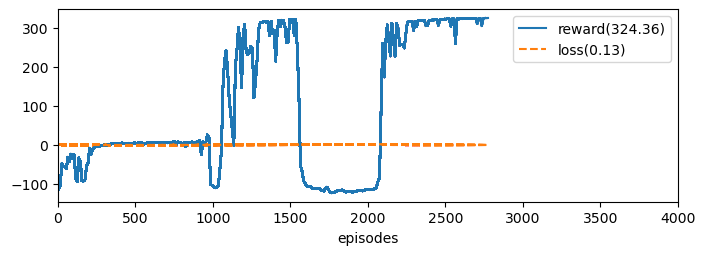

| t | episode | steps | terminated | truncated | total_reward | loss |
|-|-|-|-|-|-|-|
| 594422 | 2774 | 661 | True | False | 325.1593 | 0.1312 |  
| 594717 | 2775 | 676 | True | False | 323.1463 | 0.1265 |  
| 594894 | 2776 | 659 | True | False | 324.9289 | 0.1208 |  
| 594902 | 2777 | 661 | True | False | 324.7653 | 0.1916 |  
| 595078 | 2778 | 656 | True | False | 324.7818 | 0.1255 |  
| 595386 | 2779 | 669 | True | False | 324.3220 | 0.1309 |  
| 595560 | 2780 | 658 | True | False | 325.1206 | 0.1256 |  
| 595563 | 2781 | 669 | True | False | 324.2331 | 0.0265 |  
| 595742 | 2782 | 664 | True | False | 324.3411 | 0.1266 |  
| 596045 | 2783 | 659 | True | False | 324.8422 | 0.1200 |


In [66]:
num_envs = 4
num_episodes = 4000
show_envs_freq = 0
batch_size = 128
memory_size = 1000000
learning_rate = 1e-4
gamma = 0.99 # gamma通常取[0.95, 0.99]
tau = 0.005  # tau通常取[0.005, 0.01]
actor_update_freq = 2
hidden_size = 256
hidden_multiplier = 3
noise_std = ExpDecay(0.3, 0.1, 1000)

env = gym.make('BipedalWalker-v3', render_mode="rgb_array")
envs = gym.make_vec('BipedalWalker-v3', render_mode="rgb_array", num_envs=num_envs, vectorization_mode='sync')

clear_output()
board = ProgressBoard(xlabel='episodes', xlim=(0, num_episodes))
output = MdTailDisplay(10)
if show_envs_freq > 0:
    edisplay = EnvDisplay()
# random_run(env)
# random_run_vec(envs)

class Actor(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations, hidden_size * hidden_multiplier)
        self.layer_2 = nn.Linear(hidden_size * hidden_multiplier, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, n_actions)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return F.tanh(self.layer_3(x))

class SymActor(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations, hidden_size * hidden_multiplier)
        self.layer_2 = nn.Linear(hidden_size * hidden_multiplier, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, n_actions // 2)
        self.register_buffer('sym_index', torch.tensor([0,1,2,3,9,10,11,12,13,4,5,6,7,8,14,15,16,17,18,19,20,21,22,23], dtype=torch.long), False)
    def forward(self, x):
        x2 = x.index_select(1, self.sym_index)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.tanh(self.layer_3(x))
        x2 = F.relu(self.layer_1(x2))
        x2 = F.relu(self.layer_2(x2))
        x2 = F.tanh(self.layer_3(x2))
        return torch.cat((x, x2), 1)

class Critic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations + n_actions, hidden_size * hidden_multiplier)
        self.layer_2 = nn.Linear(hidden_size * hidden_multiplier, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, 1)
    def forward(self, s, a):
        x = torch.cat((s, a), 1)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x).squeeze(-1)

class TD3:
    def __init__(self, n_observations, n_actions, mode='default', device='cuda'):
        super().__init__()
        if mode == 'default':
            self.actor = Actor(n_observations, n_actions).to(device)
        elif mode == 'sym':
            self.actor = SymActor(n_observations, n_actions).to(device)
        self.critic_1 = Critic(n_observations, n_actions).to(device)
        self.critic_2 = Critic(n_observations, n_actions).to(device)
        if mode == 'default':
            self.target_actor = Actor(n_observations, n_actions).to(device)
        elif mode == 'sym':
            self.target_actor = SymActor(n_observations, n_actions).to(device)
        self.target_critic_1 = Critic(n_observations, n_actions).to(device)
        self.target_critic_2 = Critic(n_observations, n_actions).to(device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.optim_actor = optim.AdamW(self.actor.parameters(), lr=learning_rate, amsgrad=True)
        self.optim_critic_1 = optim.AdamW(self.critic_1.parameters(), lr=learning_rate, amsgrad=True)
        self.optim_critic_2 = optim.AdamW(self.critic_2.parameters(), lr=learning_rate, amsgrad=True)

td3 = TD3(env.observation_space.shape[0], env.action_space.shape[0])
memory = ReplayMemoryWithMask(10000)

def select_action(state, actor, noise_std=0.1, noise_clip=None, action_min=-1.0, action_max=1.0):
    with torch.no_grad():
        # 使用 Actor 网络输出动作
        action = actor(state)
        # 添加探索噪声
        noise = torch.randn_like(action, device=action.device) * noise_std
        if noise_clip is not None:
            noise = noise.clamp(-noise_clip, noise_clip)
        action = action + noise
        # 将动作限制在环境允许的范围内
        action = action.clamp(action_min, action_max)
    return action

critic_update_count = 0
Log = namedtuple('Log', ['t', 'episode', 'steps', 'terminated', 'truncated', 'total_reward', 'loss'])

i_episode = 0
total_reward = np.zeros(num_envs)
ewma_reward = EWMA(0.9)
loss_sum = 0.0
loss_count = 0
steps = np.zeros(num_envs, dtype=int)
state, _ = envs.reset()
# state (num_envs, 24)
state = torch.tensor(state, dtype=torch.float32, device='cuda')
assert state.shape == (num_envs, 24)
for t in count():
    # action (num_envs, 4)
    action = select_action(state, td3.actor, noise_std(t)).cpu()
    assert action.shape == (num_envs, 4)
    observation, reward, terminated, truncated, _ = envs.step(action.numpy())
    total_reward += reward
    steps += 1
    # reward (num_envs)
    reward = torch.tensor(reward, device='cpu')
    assert reward.shape == (num_envs,)
    # done (num_envs)
    done = torch.tensor(terminated, device='cpu')  # only terminated is mask as next_state is usable when truncated
    assert done.shape == (num_envs,)
    # next_state (num_envs, 24)
    next_state = torch.tensor(observation, dtype=torch.float32, device='cuda')
    assert next_state.shape == (num_envs, 24)
    # record the transition
    memory.push(state, action, next_state, reward, done)
    state = next_state
    # optimize model
    if len(memory) >= batch_size:
        sample = memory.sample(batch_size)
        batch = TransitionWithMask(*zip(*sample))
        done_batch = torch.cat(batch.mask).to('cuda')
        non_final_mask = ~done_batch
        next_state_batch = torch.cat(batch.next_state).to('cuda')
        non_final_next_states = next_state_batch[non_final_mask]
        # state_batch (batch_size*num_envs, 24)
        state_batch = torch.cat(batch.state).to('cuda')
        # action_batch (batch_size*num_envs, 4)
        action_batch = torch.cat(batch.action).to('cuda')
        # reward_batch (batch_size*num_envs)
        reward_batch = torch.cat(batch.reward).to('cuda')
        # state_action_values (batch_size*num_envs, 1)
        td3.critic_1.train()
        state_action_values_1 = td3.critic_1(state_batch, action_batch)
        state_action_values_2 = td3.critic_2(state_batch, action_batch)
        # next_state_values (batch_size*num_envs)
        next_state_values = torch.zeros(batch_size * num_envs, device='cuda')
        with torch.no_grad():
            non_final_next_actions = select_action(non_final_next_states, td3.target_actor, noise_std=0.1, noise_clip=0.5)
            next_state_values[non_final_mask] = torch.min(td3.target_critic_1(non_final_next_states, non_final_next_actions),
                                                        td3.target_critic_2(non_final_next_states, non_final_next_actions))
            # expected_state_action_values (batch_size*num_envs)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
        loss_1 = F.smooth_l1_loss(state_action_values_1, expected_state_action_values)
        loss_2 = F.smooth_l1_loss(state_action_values_2, expected_state_action_values)
        td3.optim_critic_1.zero_grad()
        td3.optim_critic_2.zero_grad()
        loss_1.backward()
        loss_2.backward()
        torch.nn.utils.clip_grad_norm_(td3.critic_1.parameters(), 100)
        torch.nn.utils.clip_grad_norm_(td3.critic_2.parameters(), 100)
        td3.optim_critic_1.step()
        td3.optim_critic_2.step()
        # Soft update of the target critic network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        critic_1_state_dict = td3.critic_1.state_dict()
        critic_2_state_dict = td3.critic_2.state_dict()
        target_critic_1_state_dict = td3.target_critic_1.state_dict()
        target_critic_2_state_dict = td3.target_critic_2.state_dict()
        for key in critic_1_state_dict:
            target_critic_1_state_dict[key] = critic_1_state_dict[key]*tau + target_critic_1_state_dict[key]*(1-tau)
            target_critic_2_state_dict[key] = critic_2_state_dict[key]*tau + target_critic_2_state_dict[key]*(1-tau)
        td3.target_critic_1.load_state_dict(target_critic_1_state_dict)
        td3.target_critic_2.load_state_dict(target_critic_2_state_dict)
        critic_update_count += 1
        # optimize actor
        if critic_update_count % actor_update_freq == 0:
            loss = -td3.critic_1(state_batch, td3.actor(state_batch)).mean()
            td3.optim_critic_1.zero_grad()
            td3.optim_actor.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(td3.actor.parameters(), 100)
            td3.optim_actor.step()
            # Soft update of the target actor network's weights
            target_actor_state_dict = td3.target_actor.state_dict()
            actor_state_dict = td3.actor.state_dict()
            for key in actor_state_dict:
                target_actor_state_dict[key] = actor_state_dict[key]*tau + target_actor_state_dict[key]*(1-tau)
            td3.target_actor.load_state_dict(target_actor_state_dict)
        # state avg loss
        with torch.no_grad():
            loss_sum += (loss_1 + loss_2).item()
            loss_count += 2
    # an episode done
    for i, (terminated, truncated) in enumerate(zip(terminated, truncated)):
        if terminated or truncated:
            loss_avg = (loss_sum / loss_count) if loss_count > 0 else None
            board.draw(i_episode, total_reward[i], 'reward', 10)
            board.draw(i_episode, loss_avg, 'loss', 10) if loss_avg is not None else None
            # output.print(f't {t}  episode {i_episode} terminated({terminated}) truncated({truncated}) total_reward {total_reward[i]} steps {steps[i]}') if i_episode % 10 == 0 else None
            output.tuple(Log(t, i_episode, steps[i], terminated, truncated, total_reward[i], loss_avg))
            i_episode += 1
            total_reward[i] = 0
            loss_sum = 0.0
            loss_count = 0
            steps[i] = 0
    # show the env
    if show_envs_freq > 0 and i_episode % show_envs_freq == 0:
        edisplay.show_envs(envs)
    if i_episode >= num_episodes or ewma_reward(total_reward[i]) >= 320:
        break

board.close()

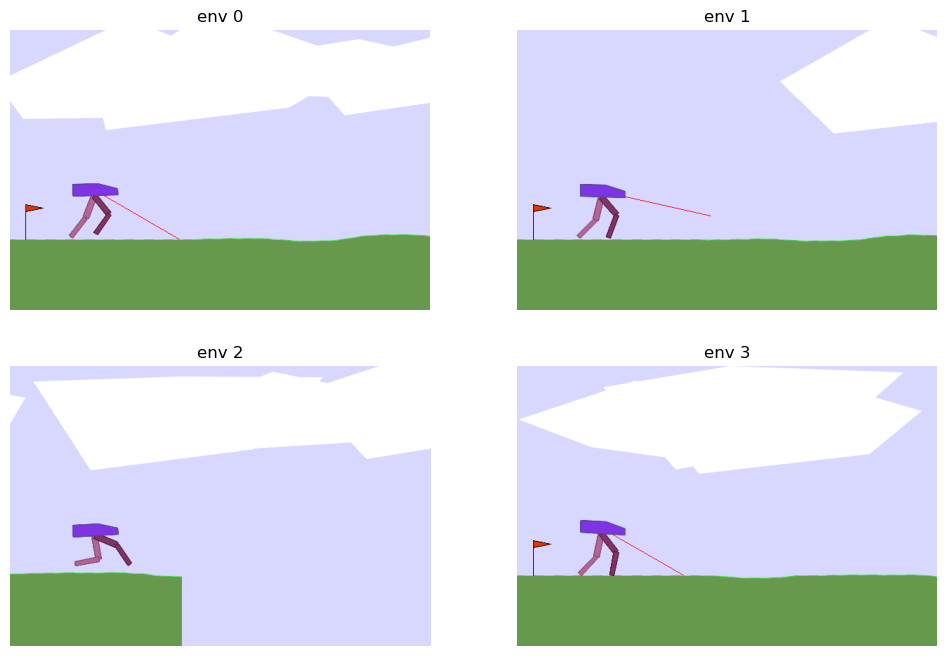

| env_0_return | env_1_return | env_2_return | env_3_return |
|-|-|-|-|
| 327.3498 | 326.9262 | 327.0451 | 327.3441 |


returns: [327.34979573 326.92616441 327.04506377 327.34406168]


In [69]:
# torch.save(td3.actor.state_dict(), '/home/data/rl/bipedal/td3_actor.pth')
# torch.save(td3.critic_1.state_dict(), '/home/data/rl/bipedal/td3_critic_1.pth')
# torch.save(td3.critic_2.state_dict(), '/home/data/rl/bipedal/td3_critic_2.pth')

# run the model            
envs = gym.make_vec('BipedalWalker-v3', render_mode="rgb_array", num_envs=4, vectorization_mode='sync')
actor_run_vec(envs, td3.actor)


# Bipedal Walker PPO

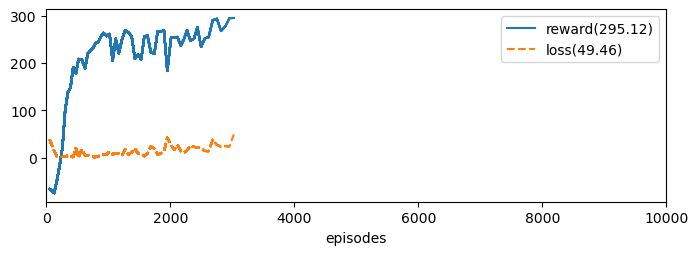

| episode | steps | terminated | truncated | total_reward | a_loss | c_loss | advantage | std |
|-|-|-|-|-|-|-|-|-|
| 3028 | 1047 | True | False | 294.0179 | 0.3716 | 89.1378 | -0.3168 | 0.4119 |  
| 3035 | 964 | True | False | 299.4253 | -0.5054 | 17.3681 | 0.2911 | 0.4003 |  
| 3043 | 999 | True | False | 295.7761 | -0.2524 | 23.7538 | -0.0636 | 0.4041 |  
| 3050 | 1044 | True | False | 294.5156 | 0.8256 | 94.6596 | 0.1544 | 0.4021 |  
| 3058 | 1070 | True | False | 293.0086 | -0.5265 | 1.8552 | -0.1082 | 0.4038 |  
| 3065 | 1054 | True | False | 292.9752 | -0.3432 | 10.6939 | 0.1771 | 0.3937 |  
| 3072 | 1012 | True | False | 297.0182 | 0.1236 | 60.2817 | 0.0840 | 0.3921 |  
| 3079 | 1020 | True | False | 296.8644 | -0.2948 | 10.4487 | 0.1453 | 0.3884 |  
| 3086 | 1021 | True | False | 298.6813 | 0.6216 | 68.8063 | -0.1298 | 0.3897 |  
| 3093 | 997 | True | False | 300.0103 | -0.7371 | 2.7338 | 0.0647 | 0.3865 |


In [34]:
import contextlib
from collections import deque

class PPOActor(nn.Module):
    """ PPO Actor predict the mean and std of the action distribution """
    def __init__(self, n_observations, n_actions, std, n_hidden=128, n_multiplier=3):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations, n_hidden * n_multiplier)
        self.layer_2 = nn.Linear(n_hidden * n_multiplier, n_hidden)
        self.layer_3 = nn.Linear(n_hidden, n_actions)
        self.std = nn.Parameter(torch.ones(n_actions) * std)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        mean = F.tanh(self.layer_3(x))
        return mean, self.std.expand_as(mean)

class PPOCritic(nn.Module):
    """ PPO Critic predict V(s) the value of the state """
    def __init__(self, n_observations, n_hidden=128, n_multiplier=3):
        super().__init__()
        self.layer_1 = nn.Linear(n_observations, n_hidden * n_multiplier)
        self.layer_2 = nn.Linear(n_hidden * n_multiplier, n_hidden)
        self.layer_3 = nn.Linear(n_hidden, 1)
    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x).squeeze(-1)

class PPO:
    def __init__(self, n_observations, n_actions, gamma, lambd, eps_clip, std=0.2, c1=1.0, c2=0.01, lr=3e-4,
                n_hidden=128, n_multiplier=3, device='cuda'):
        self.gamma = gamma
        self.lambd = lambd
        self.eps_clip = eps_clip
        self.c1 = c1
        self.c2 = c2
        self.device = device
        self.actor = PPOActor(n_observations, n_actions, std, n_hidden, n_multiplier).to(device)
        self.critic = PPOCritic(n_observations, n_hidden, n_multiplier).to(device)
        self.optim_actor = optim.AdamW(self.actor.parameters(), lr=3e-4, amsgrad=True)
        self.optim_critic = optim.AdamW(self.critic.parameters(), lr=3e-4, amsgrad=True)
    def select_action_nograd(self, state):
        with torch.no_grad():
            mean, std = self.actor(state)
            action = torch.clamp(mean + torch.randn_like(std) * std, -1.0, 1.0)
            return action, self._log_prob_normal(mean, std, action)
    def calc_traj_advantage(self, values, rewards, next_values, terms, truncs):
        # note that next_values should not be ignored for truncated trajectory
        deltas = rewards + self.gamma * next_values * ~terms - values
        advantages = torch.empty_like(deltas)
        advantages[-1] = deltas[-1]
        for t in range(len(deltas)-2, -1, -1):
            advantages[t] = deltas[t] + self.gamma * self.lambd * advantages[t+1] * ~(terms[t]|truncs[t])
        return advantages
    def total_loss(self, states, actions, old_log_probs, old_values, advantages):
        actor_loss = self.actor_loss(states, actions, old_log_probs, advantages)
        critic_loss = self.c1 * self.critic_loss(states, old_values, advantages)
        entropy_loss = self.c2 * self.entropy_loss()
        total = actor_loss + critic_loss + entropy_loss
        return total, (actor_loss, critic_loss, entropy_loss)
    def actor_loss(self, states, actions, old_log_probs, advantages):
        mean, std = self.actor(states)
        new_log_probs = self._log_prob_normal(mean, std, actions)
        ratio = (new_log_probs - old_log_probs).exp()
        return -torch.min(ratio * advantages, torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages).mean()
    def critic_loss(self, states, old_values, advantages):
        new_values = self.critic(states)
        return F.mse_loss(new_values, old_values + advantages)
    def entropy_loss(self):
        return -self.actor.std.log().sum()
    def _log_prob_normal(self, mean, std, sample):
        """ ignore constant term -0.5*ln(2*pi) """
        return -((sample - mean) / std).pow(2).sum(-1) / 2 - std.log().sum(-1)

ppo = None
max_episodes = 10000
collect_timesteps = 6400
train_epoch = 6
batch_size = 256
ppo_hp = {
    'gamma': 0.99,
    'lambd': 0.95,
    'eps_clip': 0.2,
    'std': 0.5,  # 0.4 ~ 0.5 is good, small value has bad convergence
    'c1': 4.0,   # 2.0 ~ 4.0 is good
    'c2': 0.02,  # 0.02 has good exploration
    'lr': 6e-4,  # small value will converge slowly
}

with contextlib.ExitStack() as stack:
    # monitor tools
    board = stack.enter_context(ProgressBoard(xlabel='episodes', xlim=(0, max_episodes)))
    Log = namedtuple('Log', ['episode', 'steps', 'terminated', 'truncated', 'total_reward', 'a_loss', 'c_loss', 'advantage', 'std'])
    tail_display = stack.enter_context(MdTailDisplay(10))
    env_display = stack.enter_context(EnvDisplay())
    # model setup
    env = stack.enter_context(gym.make('BipedalWalker-v3', render_mode="rgb_array"))
    ppo = PPO(env.observation_space.shape[0], env.action_space.shape[0], **ppo_hp)
    # ppo.actor.load_state_dict(torch.load('/home/data/rl/bipedal/ppo_actor.pth'))
    # ppo.critic.load_state_dict(torch.load('/home/data/rl/bipedal/ppo_critic.pth'))
    # training loop
    i_episode = -1
    while i_episode < max_episodes:
        replay_state, replay_action, replay_old_log_prob, replay_reward, replay_term, replay_trunc, replay_next_state \
            = (deque(maxlen=10000) for _ in range(7))
        # collect samples loop
        cur_timesteps = 0
        while cur_timesteps < collect_timesteps or not episode_done:
            if cur_timesteps == 0 or episode_done:
                # init episode
                i_episode += 1
                episode_done = False
                episode_reward = 0
                episode_steps = 0
                state, _ = env.reset()
                state = torch.tensor(state, dtype=torch.float32, device=ppo.device).unsqueeze(0)
            # action
            action, old_log_prob = ppo.select_action_nograd(state)
            next_state, reward, terminated, truncated, _ = env.step(action[0].cpu().numpy())
            episode_reward += reward
            episode_steps += 1
            episode_done = terminated or truncated
            # to one sample tensor
            next_state = torch.tensor(next_state, dtype=torch.float32, device=ppo.device).unsqueeze(0)
            reward = torch.tensor(reward, dtype=torch.float32, device=ppo.device).unsqueeze(0)
            term = torch.tensor(terminated, dtype=torch.bool, device=ppo.device).unsqueeze(0)
            trunc = torch.tensor(truncated, dtype=torch.bool, device=ppo.device).unsqueeze(0)
            # record
            replay_state.append(state)
            replay_action.append(action)
            replay_old_log_prob.append(old_log_prob)
            replay_reward.append(reward)
            replay_term.append(term)
            replay_trunc.append(trunc)
            replay_next_state.append(next_state)
            state = next_state
            cur_timesteps += 1
        # collect batch
        tensor_state = torch.cat(list(replay_state))
        tensor_action = torch.cat(list(replay_action))
        tensor_old_log_prob = torch.cat(list(replay_old_log_prob))
        tensor_reward = torch.cat(list(replay_reward))
        tensor_term = torch.cat(list(replay_term))
        tensor_trunc = torch.cat(list(replay_trunc))
        tensor_next_state = torch.cat(list(replay_next_state))
        with torch.no_grad():
            tensor_value = ppo.critic(tensor_state)
            tensor_next_value = ppo.critic(tensor_next_state)
        # calc advantage
        tensor_advantage = ppo.calc_traj_advantage(tensor_value, tensor_reward, tensor_next_value, tensor_term, tensor_trunc)
        # display(tensor_advantage.shape)
        # train batch
        dataset = torch.utils.data.TensorDataset(tensor_state, tensor_action, tensor_old_log_prob, tensor_value, tensor_advantage)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for _ in range(train_epoch):
            for batch in loader:
                total_loss, (actor_loss, critic_loss, _) = ppo.total_loss(*batch)
                ppo.optim_actor.zero_grad()
                ppo.optim_critic.zero_grad()
                total_loss.backward()
                ppo.optim_actor.step()
                ppo.optim_critic.step()
        # monitor output
        with torch.no_grad():
            total_loss_val, actor_loss_val, critic_loss_val = total_loss.item(), actor_loss.item(), critic_loss.item()
            avg_advantage = tensor_advantage.mean().item()
            std_val = ppo.actor.std.mean().item()
            board.draw(i_episode, episode_reward, 'reward', 10)
            board.draw(i_episode, total_loss_val, 'loss', 10)
            log = Log(i_episode, episode_steps, terminated, truncated, episode_reward, actor_loss_val, critic_loss_val, avg_advantage, std_val)
            tail_display.tuple(log)
            # env_display.show_envs(env)
            if episode_reward >= 300:
                break



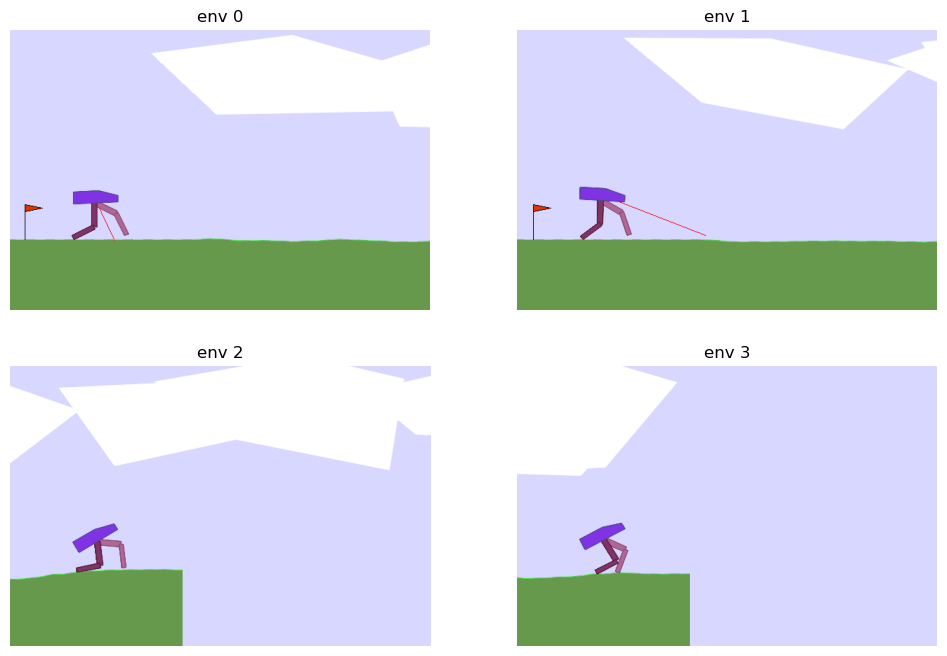

| env_0_return | env_1_return | env_2_return | env_3_return |
|-|-|-|-|
| 311.0594 | 313.4263 | 311.0834 | 311.2246 |


returns: [311.05943224 313.42630322 311.08335536 311.22463933]


In [35]:
# torch.save(ppo.actor.state_dict(), '/home/data/rl/bipedal/ppo_actor.pth')
# torch.save(ppo.critic.state_dict(), '/home/data/rl/bipedal/ppo_critic.pth')
envs = gym.make_vec('BipedalWalker-v3', render_mode="rgb_array", num_envs=4, vectorization_mode='sync')
actor_run_vec(envs, ppo.actor, True)

# Car Racing

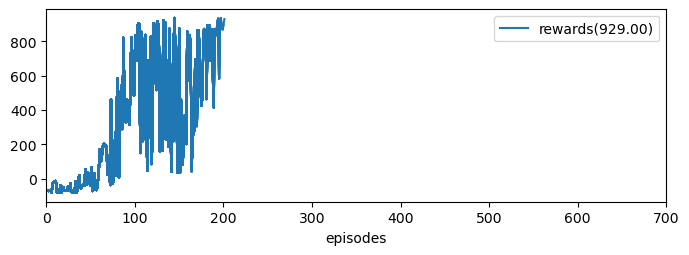

| t | i_episode | steps | rewards | term | trunc | critic_loss |
|-|-|-|-|-|-|-|
| 191800 | 192 | 1001 | 835.1635 | False | True | 0.6924 |  
| 194172 | 193 | 950 | 905.1100 | True | False | 0.5172 |  
| 194556 | 194 | 689 | 931.2046 | True | False | 0.5821 |  
| 195120 | 195 | 1001 | 582.6053 | False | True | 0.5083 |  
| 195436 | 196 | 1001 | 868.2095 | False | True | 0.5769 |  
| 197232 | 197 | 669 | 933.2045 | True | False | 0.5949 |  
| 198176 | 198 | 1001 | 877.5391 | False | True | 0.6846 |  
| 199124 | 199 | 1001 | 867.9535 | False | True | 0.7412 |  
| 199440 | 200 | 1001 | 893.6212 | False | True | 0.6655 |  
| 200076 | 201 | 711 | 929.0045 | True | False | 0.5484 |


In [3]:
import gymnasium as gym
from gymnasium.vector import VectorObservationWrapper
from gymnasium.wrappers.vector import RescaleAction
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from dlbase.funcs.decay import ExpDecay
from dlbase.funcs.avg import EWMA
from dlbase.funcs.mapping import rescale_tensor
import dlbase.rl.gyms as gyms
import dlbase.rl.algo as algo
import importlib
importlib.reload(gyms)
importlib.reload(algo)

class CarRacingEnvs(VectorObservationWrapper):
    def __init__(self, num_envs: int, **kwargs):
        rescaled_envs = RescaleAction(gym.make_vec('CarRacing-v3', num_envs=num_envs, render_mode='rgb_array', **kwargs),
                                     min_action=-1.0, max_action=1.0)
        super().__init__(rescaled_envs)
    def observations(self, observations: np.ndarray):
        assert observations.shape == (self.num_envs, 96, 96, 3)
        v = torch.tensor([car.hull.linearVelocity for car in self.unwrapped.get_attr('car')])  # type: ignore
        v = rescale_tensor(v, (0, 255), (-60, 600)).to(torch.uint8)
        observations[:, 95, 95, :2] = v
        return observations

def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, 3, padding=1))
        # layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers)

def init_weights(module: nn.Module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

vgg_arch = [(1,16),(1,32),(1,64),(1,128)]

class CarRacingCNN(nn.Module):
    def __init__(self, arch=vgg_arch, hidden_dim=128):
        super().__init__()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(*conv_blks, nn.Flatten(),
                                 nn.LazyLinear(hidden_dim * 2), nn.ReLU(),
                                 nn.LazyLinear(hidden_dim))
        with torch.no_grad():
            self(torch.randn(1, 96, 96, 3))
            init_weights(self)
    def forward(self, s: torch.Tensor):
        assert s.shape[1:] == (96, 96, 3)
        s = s.transpose(1, 3) / 255.0
        return self.net(s)

class CarRacingTD3Actor(algo.DActor):
    cnn: nn.Module
    def __init__(self, cnn: nn.Module, hidden_dim=256):
        super().__init__()
        object.__setattr__(self, 'cnn', cnn)
        self.mlp = nn.Sequential(nn.LazyLinear(hidden_dim * 2), nn.ReLU(),
                                 nn.LazyLinear(3), nn.Tanh())
        with torch.no_grad():
            self(torch.randn(1, 96, 96, 3))
            init_weights(self)
    def forward(self, s: torch.Tensor):
        with torch.no_grad():
            v = s[:, 95, 95, :2]
            s[:, 95, 95, :2] = 0
            sf = self.cnn(s)
        a = self.mlp(torch.cat([sf, v], dim=1))
        return a
        # return (a + torch.tensor([0.0, 1.0, 1.0], device=a.device)) * torch.tensor([1.0, 0.5, 0.5], device=a.device)

class CarRacingTD3Critic(algo.QCritic):
    def __init__(self, hidden_dim=256):
        super().__init__()
        self.cnn = CarRacingCNN()
        self.mlp = nn.Sequential(nn.LazyLinear(hidden_dim * 2), nn.ReLU(),
                                 nn.LazyLinear(1))
        with torch.no_grad():
            self(torch.randn(1, 96, 96, 3), torch.randn(1, 3))
            init_weights(self)
    def forward(self, s: torch.Tensor, a: torch.Tensor):
        with torch.no_grad():
            v = s[:, 95, 95, :2]
            s[:, 95, 95, :2] = 0
        return self.mlp(torch.cat([self.cnn(s), v, a], dim=1)).squeeze(-1)

def model_factory():
    critic_1 = CarRacingTD3Critic()
    critic_2 = CarRacingTD3Critic()
    actor = CarRacingTD3Actor(critic_1.cnn)
    return actor, critic_1, critic_2

env = CarRacingEnvs(num_envs=4)
td3 = algo.TD3(model_factory, explore_std_fn=ExpDecay(0.5, 0.1, 200000), batch_size=256, lr=1e-4)
ewma = EWMA(0.8)
runner = gyms.GymRunner(env, td3, show_env_freq=0, max_episodes=700, memory_size=200000, 
                        stop_on_rewards=lambda r: ewma(r) > 850, with_old_memory=None)
runner.run()


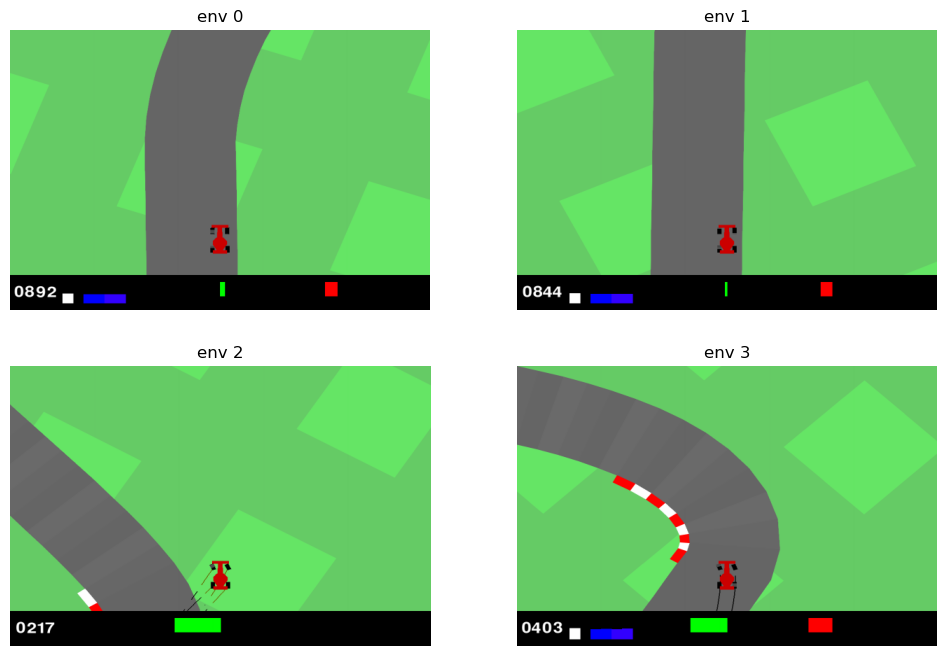

| steps | env_0_rewards | env_1_rewards | env_2_rewards | env_3_rewards |
|-|-|-|-|-|
| 1000 | 892.5496 | 844.9319 | 217.3031 | 933.9055 |


In [13]:
# torch.save(td3.actor.state_dict(), '/home/data/rl/carracing/td3_actor.pth')
# torch.save(td3.critic_1.state_dict(), '/home/data/rl/carracing/td3_critic_1.pth')
# torch.save(td3.critic_2.state_dict(), '/home/data/rl/carracing/td3_critic_2.pth')
# td3 = algo.TD3(model_factory, explore_std_fn=ExpDecay(0.5, 0.1, 200), batch_size=256, lr=1e-4)
# td3.actor.load_state_dict(torch.load('/home/data/rl/carracing/td3_actor.pth'))
# td3.critic_1.load_state_dict(torch.load('/home/data/rl/carracing/td3_critic_1.pth'))
# td3.critic_2.load_state_dict(torch.load('/home/data/rl/carracing/td3_critic_2.pth'))

importlib.reload(gyms)
importlib.reload(algo)
envs = gym.make_vec('CarRacing-v3', num_envs=4, render_mode='rgb_array')
gyms.actor_run(envs, td3.actor)